**Setup and Installations**

In [4]:
# --- INSTALLING LIBRARIES ---
!pip install --upgrade transformers accelerate datasets scikit-learn -q

# --- IMPORTING LIBRARIES ---
import pandas as pd
import numpy as np
import torch
from google.colab import drive
from huggingface_hub import notebook_login
from transformers import AutoTokenizer, TrainingArguments, Trainer, DistilBertModel
from datasets import Dataset, DatasetDict
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler, MultiLabelBinarizer
import torch.nn as nn
import matplotlib.pyplot as plt
import seaborn as sns

# --- MOUNTING GOOGLE DRIVE & LOGGING IN ---
drive.mount('/content/drive')
notebook_login()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Data Loading and Feature Preprocessing**

In [5]:
# --- LOADING THE DATASET ---
FILE_PATH = '/content/drive/MyDrive/THESIS 47/Saved Datasets/[Non English reviews deleted] All_Language_Data.csv'
df = pd.read_csv(FILE_PATH)

# --- DATA CLEANING AND FEATURE PREPROCESSING ---
df.dropna(subset=['reviewText', 'sentiment_label'], inplace=True)
df['label'] = df['sentiment_label'].astype(int)
class_names = ['Negative', 'Positive']
df['tomatoMeter'].fillna(df['tomatoMeter'].median(), inplace=True)
df['genre'].fillna("Unknown", inplace=True)
df['title'].fillna("", inplace=True)
scaler = StandardScaler()
df['tomatometer_scaled'] = scaler.fit_transform(df[['tomatoMeter']])
df['genre_list'] = df['genre'].str.split(', ')
mlb = MultiLabelBinarizer()
genre_binarized = mlb.fit_transform(df['genre_list'])
df['combined_text'] = df['title'] + " [SEP] " + df['reviewText']

# --- CREATING THE FINAL DATAFRAME ---
final_df = df[['combined_text', 'label']].copy()
final_df['numerical_features'] = list(df['tomatometer_scaled'].values)
final_df['categorical_features'] = list(genre_binarized)

/tmp/ipython-input-1418315386.py:9: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['tomatoMeter'].fillna(df['tomatoMeter'].median(), inplace=True)
/tmp/ipython-input-1418315386.py:10: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inp

**Dataset Preparation and Tokenization**

In [6]:
# --- SPLITTING AND CONVERTING TO HUGGING FACE DATASET ---
train_df, test_df = train_test_split(final_df, test_size=0.2, random_state=42, stratify=final_df['label'])
raw_multimodal_datasets = DatasetDict({
    'train': Dataset.from_pandas(train_df),
    'test': Dataset.from_pandas(test_df)
})

# --- TOKENIZATION ---
MODEL_CHECKPOINT = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(MODEL_CHECKPOINT)
def tokenize_multimodal_function(examples):
    return tokenizer(examples["combined_text"], padding="max_length", truncation=True, max_length=256)
tokenized_multimodal_datasets = raw_multimodal_datasets.map(tokenize_multimodal_function, batched=True)
tokenized_multimodal_datasets = tokenized_multimodal_datasets.remove_columns(["combined_text", "__index_level_0__"])
tokenized_multimodal_datasets.set_format("torch")

Map:   0%|          | 0/155840 [00:00<?, ? examples/s]

Map:   0%|          | 0/38961 [00:00<?, ? examples/s]

**Custom Model and Data Collator**

In [7]:
# --- DEFINING THE CUSTOM MULTIMODAL MODEL ---
class MultimodalClassifier(nn.Module):
    def __init__(self, num_labels, num_numerical_features, num_categorical_features):
        super(MultimodalClassifier, self).__init__()
        self.distilbert = DistilBertModel.from_pretrained(MODEL_CHECKPOINT)
        self.dropout = nn.Dropout(0.2)
        self.classifier = nn.Linear(
            self.distilbert.config.hidden_size + num_numerical_features + num_categorical_features, num_labels)
        self.num_labels = num_labels
    def forward(self, input_ids, attention_mask, numerical_features, categorical_features, labels=None):
        distilbert_output = self.distilbert(input_ids=input_ids, attention_mask=attention_mask)
        cls_token_output = distilbert_output.last_hidden_state[:, 0]
        pooled_output = self.dropout(cls_token_output)
        numerical_features = numerical_features.unsqueeze(1)
        combined_features = torch.cat([pooled_output, numerical_features, categorical_features], dim=1)
        logits = self.classifier(combined_features)
        loss = None
        if labels is not None:
            loss_fct = nn.CrossEntropyLoss()
            loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))
        return (loss, logits) if loss is not None else (None, logits)

# --- CUSTOM DATA COLLATOR ---
class MultimodalDataCollator:
    def __init__(self, tokenizer):
        self.tokenizer = tokenizer
    def __call__(self, features):
        batch = self.tokenizer.pad(
            [{ "input_ids": f["input_ids"], "attention_mask": f["attention_mask"] } for f in features], return_tensors="pt")
        numerical_features = np.array([f['numerical_features'] for f in features])
        categorical_features = np.array([f['categorical_features'] for f in features])
        batch['labels'] = torch.tensor([f['label'] for f in features], dtype=torch.long)
        batch['numerical_features'] = torch.tensor(numerical_features, dtype=torch.float)
        batch['categorical_features'] = torch.tensor(categorical_features, dtype=torch.float)
        return batch

**Training the Multimodal Model**

In [10]:
# --- INITIALIZING THE CUSTOM MODEL AND COLLATOR ---
num_numerical_features = 1
num_categorical_features = len(mlb.classes_)
multimodal_model = MultimodalClassifier(
    num_labels=2,
    num_numerical_features=num_numerical_features,
    num_categorical_features=num_categorical_features
)
data_collator = MultimodalDataCollator(tokenizer)

# --- CORRECTED EVALUATION METRICS FUNCTION ---
def compute_metrics(pred):
    labels = pred.label_ids
    # This corrected line handles the prediction format correctly
    preds = pred.predictions[0].argmax(-1) if isinstance(pred.predictions, tuple) else pred.predictions.argmax(-1)

    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='binary')
    acc = accuracy_score(labels, preds)
    return {'accuracy': acc, 'f1': f1, 'precision': precision, 'recall': recall}

# --- DEFINING TRAINING ARGUMENTS ---
multimodal_training_args = TrainingArguments(
    output_dir="/content/drive/MyDrive/THESIS 47/Saved Datasets/results_binary_multimodal",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
)

# --- INITIALIZING THE TRAINER ---
multimodal_trainer = Trainer(
    model=multimodal_model,
    args=multimodal_training_args,
    train_dataset=tokenized_multimodal_datasets["train"],
    eval_dataset=tokenized_multimodal_datasets["test"],
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

# --- STARTING THE TRAINING ---
print("\n--- Starting Training for Multimodal Binary Model ---")
multimodal_trainer.train()


--- Starting Training for Multimodal Binary Model ---


Epoch,Training Loss,Validation Loss


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.307400,0.308789,0.875055,0.873368,0.888718,0.858538
2,0.225100,0.312579,0.882960,0.883804,0.880707,0.886923
3,0.157200,0.400571,0.882780,0.883026,0.884454,0.881604


TrainOutput(global_step=29220, training_loss=0.24338036392911666, metrics={'train_runtime': 10429.336, 'train_samples_per_second': 44.827, 'train_steps_per_second': 2.802, 'total_flos': 0.0, 'train_loss': 0.24338036392911666, 'epoch': 3.0})

**Enhanced Evaluation for Multimodal Binary Model**

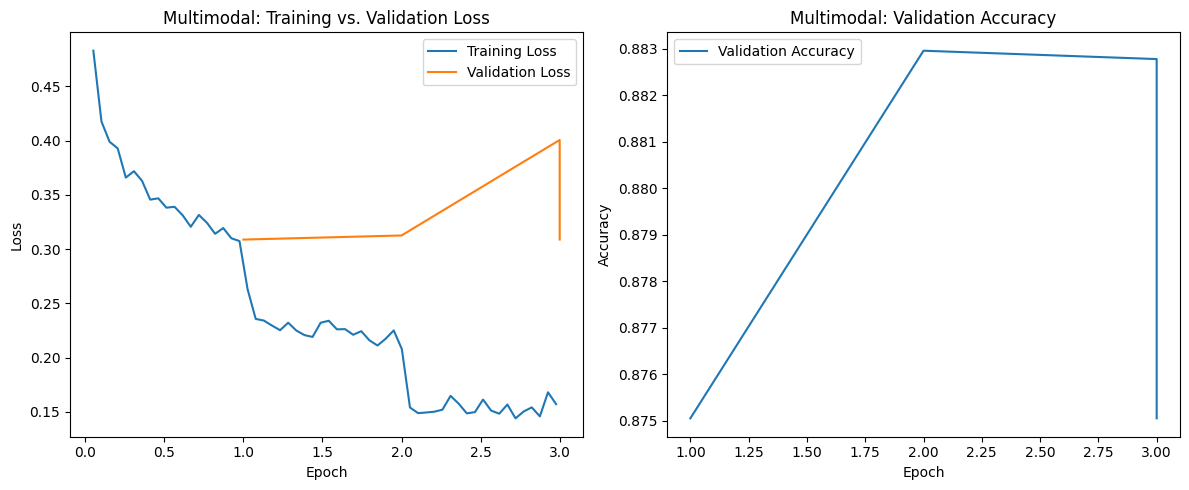


--- Final Evaluation on Test Set (Multimodal) ---


{'eval_loss': 0.3087894022464752, 'eval_accuracy': 0.8750545417212083, 'eval_f1': 0.8733676707767546, 'eval_precision': 0.8887183016570491, 'eval_recall': 0.8585383317138036, 'eval_runtime': 270.2416, 'eval_samples_per_second': 144.171, 'eval_steps_per_second': 9.014, 'epoch': 3.0}
Logits shape: (38961, 2)

--- Classification Report (Multimodal) ---
              precision    recall  f1-score   support

    Negative       0.86      0.89      0.88     19408
    Positive       0.89      0.86      0.87     19553

    accuracy                           0.88     38961
   macro avg       0.88      0.88      0.88     38961
weighted avg       0.88      0.88      0.88     38961



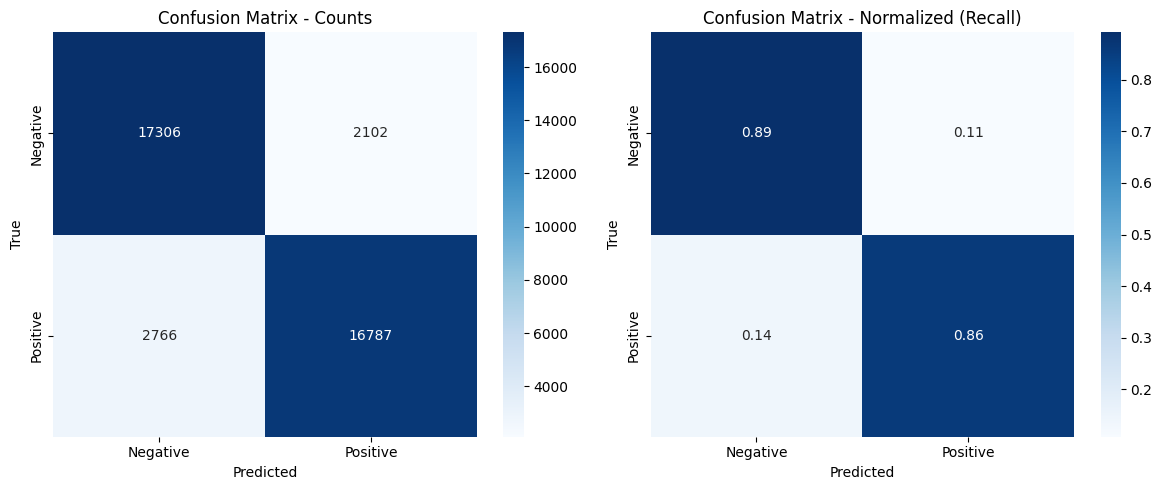

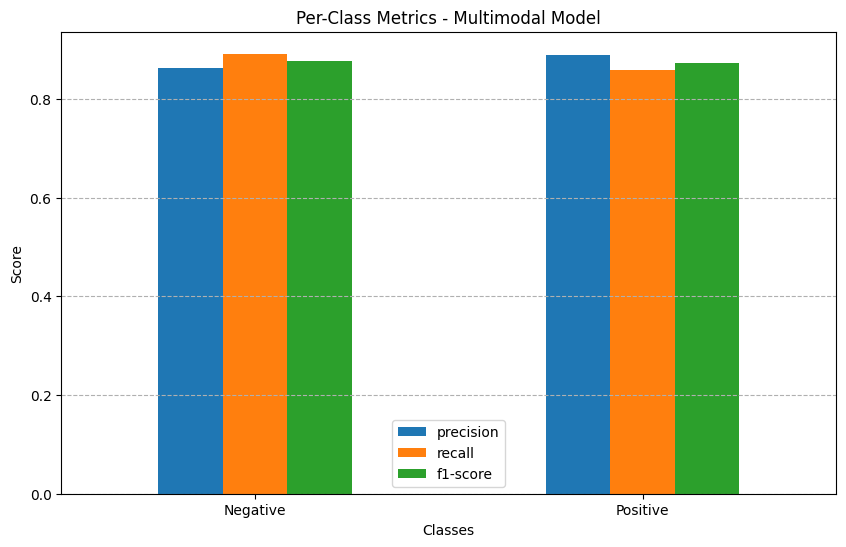


Multimodal model saved to: /content/drive/MyDrive/THESIS 47/Saved Datasets/[Binary]fine-tuned_multimodal
First 10 preds vs true: [(np.int64(0), np.int64(0)), (np.int64(0), np.int64(0)), (np.int64(1), np.int64(0)), (np.int64(0), np.int64(0)), (np.int64(1), np.int64(1)), (np.int64(1), np.int64(1)), (np.int64(0), np.int64(0)), (np.int64(0), np.int64(0)), (np.int64(0), np.int64(0)), (np.int64(0), np.int64(1))]


In [13]:
# ==========================
# EVALUATE • REPORT • PLOTS • SAVE (Multimodal)
# ==========================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix


try:
    class_names
except NameError:
    # Try to infer from model config; otherwise fall back to generic names
    num_labels = getattr(multimodal_trainer.model.config, "num_labels", None)
    if num_labels is None:
        # last resort: infer from dataset labels
        uniq = sorted(set(tokenized_multimodal_datasets["test"]["label"]))
        num_labels = len(uniq)
    class_names = [f"Class {i}" for i in range(num_labels)]
    print(f"[Info] 'class_names' not found; using defaults: {class_names}")

# --- EXTRACT TRAINING HISTORY ---
log_history = multimodal_trainer.state.log_history
train_logs = [log for log in log_history if ('loss' in log and 'eval_loss' not in log)]
eval_logs = [log for log in log_history if ('eval_loss' in log)]

# --- 1) TRAIN vs VALID LOSS & ACCURACY ---
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot([log.get('epoch', i) for i, log in enumerate(train_logs, 1)],
         [log['loss'] for log in train_logs], label='Training Loss')
plt.plot([log.get('epoch', i) for i, log in enumerate(eval_logs, 1)],
         [log['eval_loss'] for log in eval_logs], label='Validation Loss')
plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.title('Multimodal: Training vs. Validation Loss'); plt.legend()

plt.subplot(1, 2, 2)
if len(eval_logs) > 0 and 'eval_accuracy' in eval_logs[0]:
    plt.plot([log.get('epoch', i) for i, log in enumerate(eval_logs, 1)],
             [log['eval_accuracy'] for log in eval_logs], label='Validation Accuracy')
    plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.title('Multimodal: Validation Accuracy'); plt.legend()
else:
    plt.text(0.5, 0.5, 'No eval accuracy logged', ha='center', va='center')
    plt.axis('off')

plt.tight_layout()
plt.show()

# --- 2) FINAL EVALUATION ON TEST SET ---
print("\n--- Final Evaluation on Test Set (Multimodal) ---")
multimodal_eval_results = multimodal_trainer.evaluate()
print(multimodal_eval_results)

pred_out = multimodal_trainer.predict(tokenized_multimodal_datasets["test"])

# HF Trainer returns PredictionOutput(predictions, label_ids, metrics)
# predictions can be ndarray or a tuple like (logits, ...)
logits = pred_out.predictions
if isinstance(logits, (list, tuple)):
    logits = logits[0]
logits = np.asarray(logits)

print("Logits shape:", logits.shape)

# --- 3) CONVERT LOGITS -> LABELS (robust to shape) ---
if logits.ndim == 2:
    # Multi-class: (N, C)
    multimodal_predicted_labels = np.argmax(logits, axis=-1)
    num_classes = logits.shape[1]
elif logits.ndim == 1:
    # Single-logit binary: (N,)
    # Trainer returns raw logits (pre-sigmoid), so threshold at 0
    multimodal_predicted_labels = (logits > 0).astype(int)
    num_classes = 2
else:
    raise ValueError(f"Unexpected logits ndim: {logits.ndim}")

# --- Ensure class_names length matches classes ---
if len(class_names) != num_classes:
    print(f"[Warn] Adjusting class_names from {len(class_names)} to {num_classes}.")
    class_names = [f"Class {i}" for i in range(num_classes)]

# True labels
true_labels = np.asarray(tokenized_multimodal_datasets["test"]["label"]).astype(int)

# --- 4) CLASSIFICATION REPORT ---
print("\n--- Classification Report (Multimodal) ---")
report_text = classification_report(true_labels, multimodal_predicted_labels,
                                    target_names=class_names, zero_division=0)
print(report_text)

report = classification_report(true_labels, multimodal_predicted_labels,
                               target_names=class_names, output_dict=True, zero_division=0)

# --- 5) CONFUSION MATRICES ---
cm = confusion_matrix(true_labels, multimodal_predicted_labels, labels=list(range(num_classes)))
# Avoid division by zero for classes with zero support
row_sums = cm.sum(axis=1, keepdims=True)
row_sums[row_sums == 0] = 1
cm_norm = cm.astype('float') / row_sums

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted'); plt.ylabel('True'); plt.title('Confusion Matrix - Counts')

plt.subplot(1, 2, 2)
sns.heatmap(cm_norm, annot=True, fmt='.2f', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted'); plt.ylabel('True'); plt.title('Confusion Matrix - Normalized (Recall)')
plt.tight_layout()
plt.show()

# --- 6) PER-CLASS METRICS BAR CHART ---
report_df = pd.DataFrame(report).transpose()
# Filter only your classes (exclude 'accuracy', 'macro avg', 'weighted avg')
report_df_classes = report_df.loc[[cn for cn in class_names if cn in report_df.index]]

ax = report_df_classes[['precision', 'recall', 'f1-score']].plot(
    kind='bar', figsize=(10, 6))
plt.title('Per-Class Metrics - Multimodal Model')
plt.xlabel('Classes'); plt.ylabel('Score')
plt.xticks(rotation=0); plt.grid(axis='y', linestyle='--'); plt.legend()
plt.show()

# --- 7) SAVE MODEL ---
output_multimodal_model_path = "/content/drive/MyDrive/THESIS 47/Saved Datasets/[Binary]fine-tuned_multimodal"
multimodal_trainer.save_model(output_multimodal_model_path)
print(f"\nMultimodal model saved to: {output_multimodal_model_path}")

# --- 8) OPTIONAL: QUICK PEEK ---
print("First 10 preds vs true:",
      list(zip(multimodal_predicted_labels[:10], true_labels[:10])))
